# Log your first custom charts

To keep this example simple, we generate random data to log. The focus here is on the mechanics of logging a customizable chart.

1. Initialize a run with `wandb.init()`
2. Log normal model metrics with `wandb.log()`
3. Set up a table of data to use in charts
4. Log customizable charts with `wandb.plot`

**Note you may need to set environment variables depending on the type of deployment you are using.**

In [ ]:
import wandb
import random
import math
import os

In [ ]:
# Set environment variables as needed

#os.environ['WANDB_API_KEY'] = ''
#os.environ['WANDB_BASE_URL'] = ''
#os.environ['WANDB_NOTEBOOK_NAME'] = ''

In [ ]:
# Start a new run
run = wandb.init(project='custom-charts')
offset = random.random()

# At each time step in the model training loop
for run_step in range(20):
    
    # Log basic experiment metrics, which show up as standard line plots in the UI
    wandb.log({
        "acc": math.log(1 + random.random() + run_step) + offset,
        "val_acc": math.log(1 + random.random() + run_step) + offset * random.random(),
    }, commit=False)

    # Set up data to log in custom charts
    data = []
    for i in range(100):
        data.append([i, random.random() + math.log(1 + i) + offset + random.random()])

    # Create a table with the columns to plot
    table = wandb.Table(data=data, columns=["step", "height"])

    # Use the table to populate various custom charts
    line_plot = wandb.plot.line(table, x='step', y='height', title='Line Plot')
    histogram = wandb.plot.histogram(table, value='height', title='Histogram')
    scatter = wandb.plot.scatter(table, x='step', y='height', title='Scatter Plot')

    # Log custom tables, which will show up in customizable charts in the UI
    wandb.log({'line_1': line_plot, 
             'histogram_1': histogram, 
             'scatter_1': scatter})

# Finally, end the run. We only need this ine in Jupyter notebooks.
run.finish()

# Customize a chart
1. **Rerun the cell above** to get multiple runs in your project. This will let you compare data across runs on the charts in the project page.
1. **Open the project link** printed out above, under the previous cell. Inside the dashboard, click around on different runs and edit the charts.
1. **Edit the Vega spec** to your liking by clicking edit on the chart. 

Here's what that looks like in the UI:

![](https://i.imgur.com/HmiQe7W.gif)

Once you have a visualization you like, you can log it from your script. Here's an example where I'm logging the new version of the histogram directly.


In [ ]:
# Start a new run
run = wandb.init(project='custom-charts',
                 notes='Custom stacked bar chart')
offset = random.random()

# Set up data to log in custom charts
data = []
for i in range(100):
    data.append([i, random.random() + math.log(1 + i) + offset + random.random()])

# Create a table with the columns to plot
table = wandb.Table(data=data, columns=["step", "height"])

# Map from the table's columns to the chart's fields
fields = {"x": "step",
          "value": "height"}

# Use the table to populate the new custom chart preset
# To use your own saved chart preset, change the vega_spec_name
my_custom_chart = wandb.plot_table(vega_spec_name="carey/new_chart",
              data_table=table,
              fields=fields,
              )

# Log the plot to have it show up in the UI
wandb.log({"custom_chart": my_custom_chart})

# Finally, end the run. We only need this ine in Jupyter notebooks.
run.finish()

Run the cell above and check the project page again — a new custom chart should have appeared, this time it's a stacked bar chart. 

Log a chart from your own custom preset with these quick steps:
1. Create a preset in the UI, and click **Save As** to save it under a name.
2. Copy that `vega_spec_name` and use it in your script.
3. Run the script and see the new chart show up automatically in your new runs.

# Advanced: Detailed Data Logging and Custom Chart Creation

## Create a table with time series data and plot the data
- We will use the `pandas_datareader` package. You can install it via `pip install pandas-datareader`
- This will generate a table in W&B which you can use to create a number of plots. You can also use a custom chart as above to apply a preset custom spec.

In [ ]:
import pandas as pd
from pandas_datareader import data

In [ ]:
config_defaults = dict(sym = 'AAPL',
                       start_date = '2010-01-01',
                       end_date = '2016-12-31',
                       source = 'yahoo')

In [ ]:
run = wandb.init(config=config_defaults, project='custom-charts')

# Load data
# Note that data providers such as Yahoo can throttle you if you are making many requests in a short period of time.

prices = data.DataReader(wandb.config.sym, wandb.config.source, wandb.config.start_date, wandb.config.end_date)
prices = prices.reset_index()

# Create a W&B Table object

prices_table = wandb.Table(data=prices.values.tolist(), columns=prices.columns.values.tolist())

# Log Table in W&B

wandb.log({f"{wandb.config.sym.lower()}_price_table":prices_table})

# Complete run
run.finish()

## Prepare the Vega Spec for W&B

You should now see a table in the project with the name `<sym>_price_table`. We will not create a `vega_spec` to plot this data.

https://vega.github.io/ has many examples of the types of charts you can plot. We will be using a simple line chart example with the `x` axis set to the `temporal` type. The specific spec can be found here: https://vega.github.io/vega-lite/examples/line.html

Let's look at the base spec and see what needs to be changed:

```
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "Google's stock price over time.",
  "data": {"url": "data/stocks.csv"},
  "transform": [{"filter": "datum.symbol==='GOOG'"}],
  "mark": "line",
  "encoding": {
    "x": {"field": "date", "type": "temporal"},
    "y": {"field": "price", "type": "quantitative"}
  }
}
```

In order to make this spec compatible with W&B Custom Charts, you will need to modify a few lines:

* `"data": {"url": "data/stocks.csv"}` should be changed to read from the `wandb` object which passes the data to Vega from the graphql api.
* Since we are not going to manipulate the data, we will remove the `"transform": [{"filter": "datum.symbol==='GOOG'"}]` line. 
* We want to control what data is passed to each field vs setting static data points. Replace `"field": "static_field"` with `"field":"${field:period}"`.
* Modify the data type if necessary. In this case `temporal` is the appropriate type for the `x` axis.
* Add an encoding to specify the name of run by color using `"color": {field": "${field:run_name}", "type": "ordinal"}`

Your final spec should look like this:

```
{
  "$schema": "https://vega.github.io/schema/vega-lite/v4.json",
  "description": "Provide your description here.",
  "data": {"name": "wandb"},
  "mark": "line",
  "encoding": {
    "x": {"field": "${field:period}", "type": "temporal"},
    "y": {"field": "${field:prices}", "type": "quantitative"},
    "color": {"field": "${field:run_name}", "type": "ordinal"}
  }
}
```

## Create a Custom Chart

1) Go to your project: `custom-charts`

2) Add a Custom Chart:

<div>
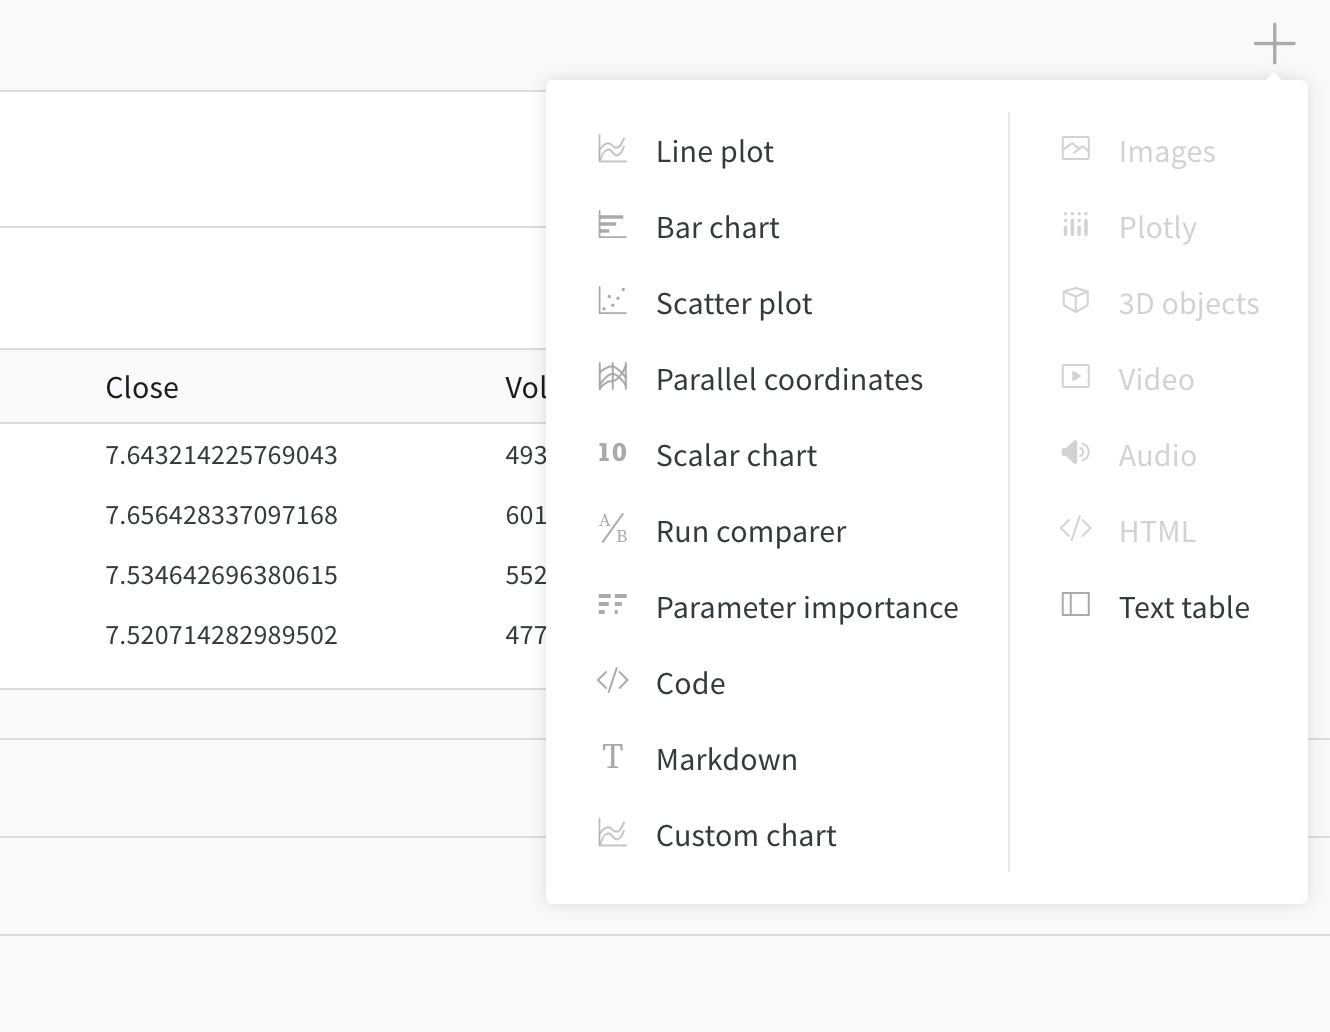
</div>


3) Select `summaryTable` and the name of your table from the graphql interface:

<div>
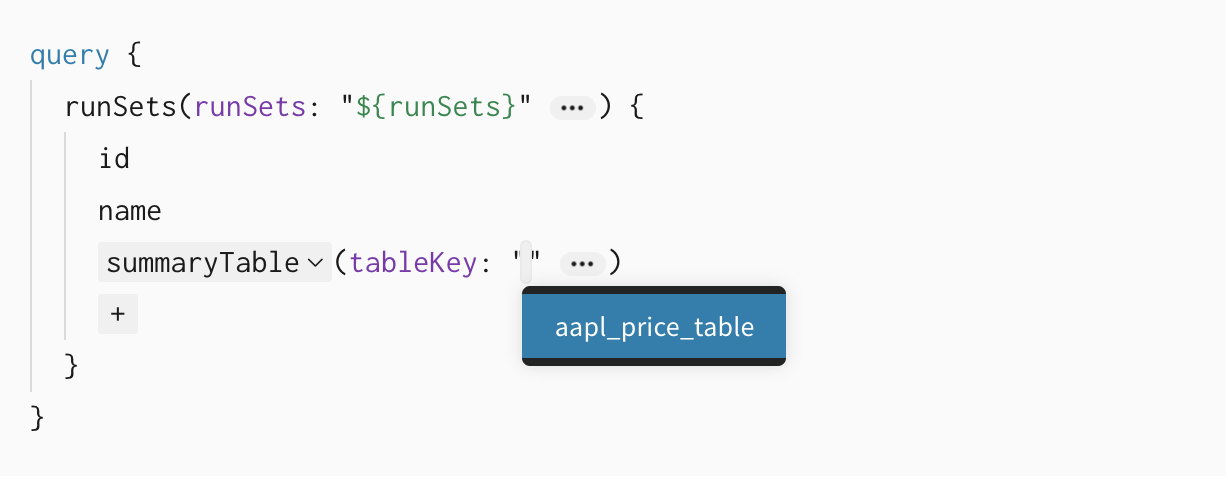
</div>


4) Edit the current Vega Spec:

<div>
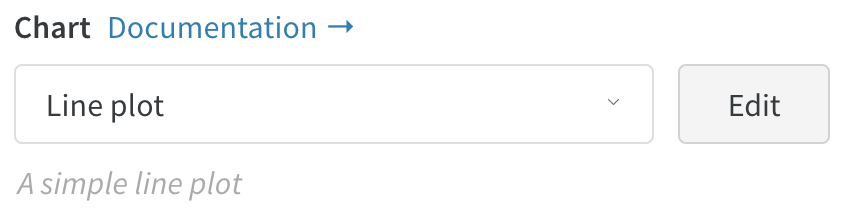
</div>


5) Paste the Vega Spec prepared above:

<div>
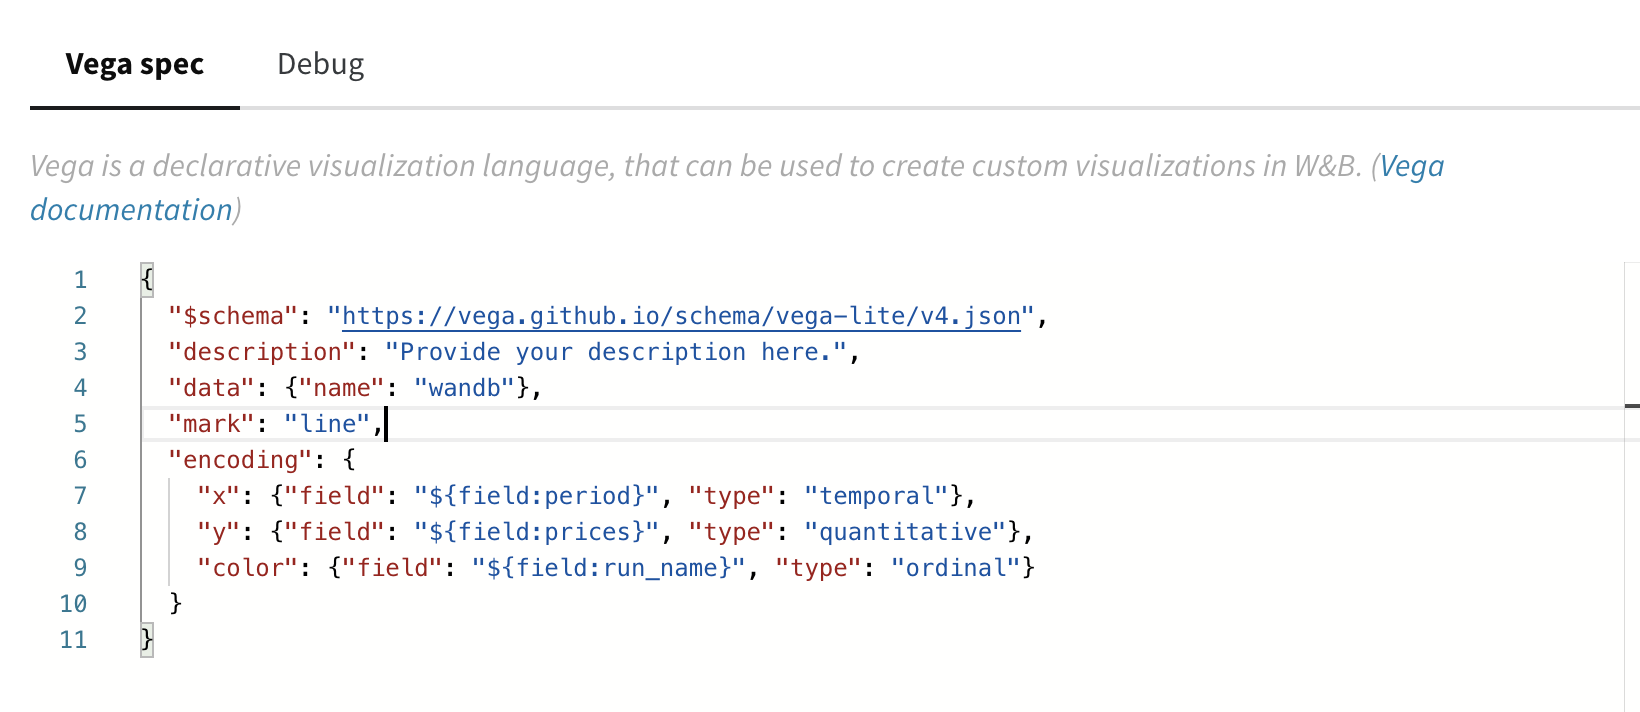
</div>


6) Select the fields for `x`, `y` and `color` on the bottom right of the screen and you should see the chart display your price data:

<div>
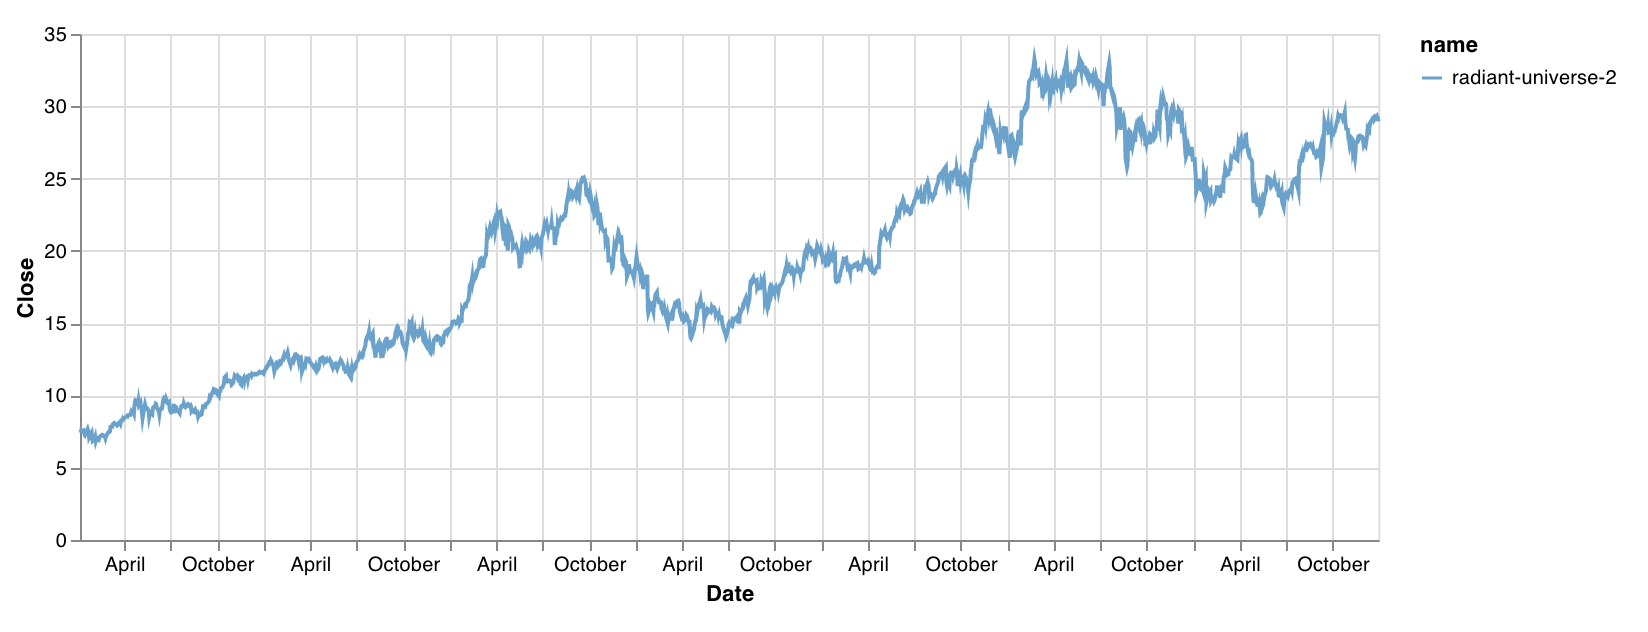
</div>

7) Click `Apply custom panel visualization` to Save. You can also save the template as per above by using the `Save As` button which will allow you to call the spec programatically as explained above using `vega_spec_name` in the `wandb.plot.table()` function.